# Mini Challenge: Deep Learning for Images and Signals
- Name: Nils Fahrni
- Date: 12.12.2024

## Question: tbd

## Package Usage

In [1]:
%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "dlbs"

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import wandb

env: WANDB_SILENT=True
env: "WANDB_NOTEBOOK_NAME"="dlbs"


## Dataset
https://arxiv.org/abs/1805.04687

In [2]:
subfolders = ['train', 'val', 'test']

for subfolder in subfolders:
    data_folder = os.path.join('data', f'bdd100k_{subfolder}', 'images', '10k', subfolder)
    labels_folder = os.path.join('data', 'bdd100k_labels', 'labels', 'sem_seg', 'colormaps', subfolder)

    out = f'Number of images in {subfolder}: {len(os.listdir(data_folder))}'
    if os.path.exists(labels_folder):
        out += f' (with {len(os.listdir(labels_folder))} Labels)'
    else :
        out += ' (without Labels)'
    print(out)

Number of images in train: 7000 (with 7000 Labels)
Number of images in val: 1000 (with 1000 Labels)
Number of images in test: 2000 (without Labels)


### Exploration

[Become one with the data](https://karpathy.github.io/2019/04/25/recipe/#:~:text=1.%20Become%20one%20with%20the%20data)

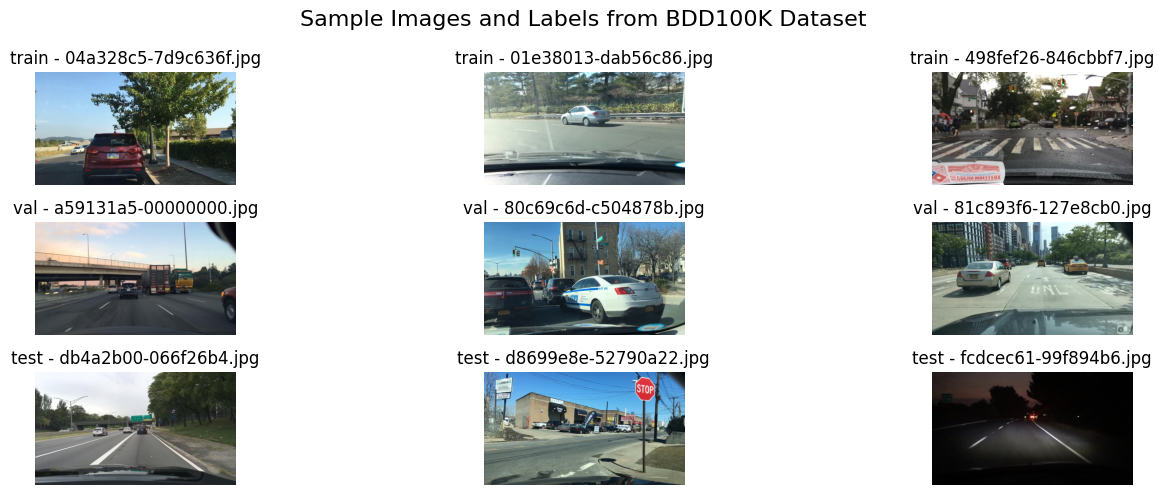

In [3]:
fig, axs = plt.subplots(3, 3, figsize=(15, 5))

fig.suptitle('Sample Images and Labels from BDD100K Dataset', fontsize=16)

for i, subfolder in enumerate(subfolders):
    data_folder = os.path.join('data', f'bdd100k_{subfolder}', 'images', '10k', subfolder)
    labels_folder = os.path.join('data', 'bdd100k_labels', 'labels', 'sem_seg', 'colormaps', subfolder)
    for j, file in enumerate(os.listdir(data_folder)[:3]):
        img = plt.imread(os.path.join(data_folder, file))
        axs[i, j].imshow(img)
        axs[i, j].set_title(f'{subfolder} - {file}')
        axs[i, j].axis('off')
        label_file = os.path.join(labels_folder, file)
        if os.path.exists(label_file):
            print(label)
            label = plt.imread(label_file)
            axs[i, j].imshow(label)

plt.tight_layout()
plt.show()

### Training and Evaluation Skeleton & Baseline Model

[Set up the end-to-end training/evaluation skeleton + get dumb baselines](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Set%20up%20the%20end%2Dto%2Dend%20training/evaluation%20skeleton%20%2B%20get%20dumb%20baselines)

In [4]:
import torch
import torch.nn as nn
from torcheval.metrics import MulticlassAccuracy

RANDOM_SEED = 1337

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


#### Data Loading & Splitting

In [11]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class BDD100KDataset(Dataset):
    def __init__(self, images_dir, labels_dir=None, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform or transforms.ToTensor()
        self.target_transform = target_transform or transforms.ToTensor()

        self.image_filenames = os.listdir(images_dir)
        
        if labels_dir:
            self.label_filenames = os.listdir(labels_dir)
        else:
            self.label_filenames = None

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        try:
            image_path = os.path.join(self.images_dir, self.image_filenames[idx])
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)

            if self.label_filenames:
                label_path = os.path.join(self.labels_dir, self.label_filenames[idx])
                label = Image.open(label_path).convert('L')
                if self.target_transform:
                    label = self.target_transform(label).squeeze(0).long()
                return image, label
            else:
                return image
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            return None



class BDD100KDataLoader:
    def __init__(self, root_dir, transform=None, val_split=0.2, batch_size=32, shuffle=True):
        self.root_dir = root_dir
        self.transform = transform or transforms.ToTensor()
        self.val_split = val_split
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.train_dir = os.path.join(root_dir, 'bdd100k_train', 'images', '10k', 'train')
        self.val_dir = os.path.join(root_dir, 'bdd100k_val', 'images', '10k', 'val')
        self.train_labels_dir = os.path.join(root_dir, 'bdd100k_labels', 'labels', 'sem_seg', 'colormaps', 'train')
        self.val_labels_dir = os.path.join(root_dir, 'bdd100k_labels', 'labels', 'sem_seg', 'colormaps', 'val')
        
    def load_datasets(self):
        train_dataset = BDD100KDataset(self.train_dir, self.train_labels_dir, transform=self.transform)
        val_dataset = BDD100KDataset(self.val_dir, self.val_labels_dir, transform=self.transform)

        total_train_size = len(train_dataset)
        val_size = int(total_train_size * self.val_split)
        train_size = total_train_size - val_size

        train_split, val_split = random_split(train_dataset, [train_size, val_size])
        
        return train_split, val_split

    def get_data_loaders(self):
        train_split, val_split = self.load_datasets()

        train_loader = DataLoader(train_split, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=0)
        val_loader = DataLoader(val_split, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=0)

        return train_loader, val_loader

    def get_test_loader(self):
        test_dir = os.path.join(self.root_dir, 'bdd100k_test', 'images', '10k', 'test')
        test_dataset = BDD100KDataset(test_dir, transform=self.transform)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
        
        return test_loader



#### Training and Evaluation Skeleton

In [35]:
import torch
import wandb
from torchmetrics import  JaccardIndex
from torchmetrics import Dice

class Trainer:
    def __init__(self, model, criterion, optimizer, lr, epochs, weight_init, seed, device, verbose, run_name):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.weight_init = weight_init
        self.seed = seed
        self.device = device
        self.verbose = verbose
        self.run_name = run_name

        self.model.to(self.device)
        self.iou_metric = JaccardIndex(num_classes=21, task="multiclass").to(self.device)
        self.dice_metric = Dice(num_classes=21).to(self.device)

        self._set_seed(self.seed)

        wandb.init(project="bdd100k_model_training", name=self.run_name)
        #wandb.watch(self.model, log="all")

    def _set_seed(self, seed):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

    def _initialize_weights(self):
        if self.weight_init:
            self.model.apply(self.weight_init)

    def _train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        self.iou_metric.reset()
        self.dice_metric.reset()
        
        for images, labels in train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            self.iou_metric.update(predicted, labels)
            self.dice_metric.update(predicted, labels)

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100. * correct / total
        iou_score = self.iou_metric.compute().item()
        dice_score = self.dice_metric.compute().item()

        return epoch_loss, accuracy, iou_score, dice_score

    def _validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        self.iou_metric.reset()
        self.dice_metric.reset()

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update IoU and Dice metrics
                self.iou_metric.update(predicted, labels)
                self.dice_metric.update(predicted, labels)

        epoch_loss = running_loss / len(val_loader)
        accuracy = 100. * correct / total
        iou_score = self.iou_metric.compute().item()
        dice_score = self.dice_metric.compute().item()

        return epoch_loss, accuracy, iou_score, dice_score

    def run(self, train_loader, val_loader):
        self._initialize_weights()

        for epoch in range(self.epochs):
            train_loss, train_acc, train_iou, train_dice = self._train_epoch(train_loader)
            val_loss, val_acc, val_iou, val_dice = self._validate_epoch(val_loader)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs} - "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% - "
                      f"Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f} - "
                      f"Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")

            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "train_iou": train_iou,
                "train_dice": train_dice,
                "val_iou": val_iou,
                "val_dice": val_dice
            })

    def test(self, test_loader):
        test_loss, test_acc, test_iou, test_dice = self._validate_epoch(test_loader)

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}% - "
              f"Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}")

        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc,
            "test_iou": test_iou,
            "test_dice": test_dice
        })

    def _save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)


#### Baseline (Tiny-)U-Net

In [36]:
class UNetBaseline(nn.Module):
    def __init__(self, num_classes):
        super(UNetBaseline, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        x_enc = self.encoder(x)
        x_bottleneck = self.bottleneck(x_enc)
        x_dec = self.decoder(x_bottleneck)
        output = self.final_layer(x_dec)
        
        return output

num_classes = 21
model = UNetBaseline(num_classes=num_classes)
input_tensor = torch.randn(1, 3, 256, 256)
output = model(input_tensor)
print(output.shape)

torch.Size([1, 21, 256, 256])


In [37]:
dataloader = BDD100KDataLoader(root_dir='data', batch_size=128)

train_loader, val_loader = dataloader.get_data_loaders()
test_loader = dataloader.get_test_loader()

model = UNetBaseline(num_classes=num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    lr=0.001,
    epochs=10,
    weight_init=None,
    seed=42,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=True,
    run_name="bdd100k_experiment"
)

trainer.run(train_loader, val_loader)

trainer.test(test_loader)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/nils/.pyenv/versions/3.12.4/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nils/.pyenv/versions/3.12.4/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'BDD100KDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

### Overfit

[Overfit](https://karpathy.github.io/2019/04/25/recipe/#:~:text=3.-,Overfit,-At%20this%20stage)

### Regularization

[Regularize](https://karpathy.github.io/2019/04/25/recipe/#:~:text=4.-,Regularize,-Ideally%2C%20we%20are)

### Tuning the model

[Tune](https://karpathy.github.io/2019/04/25/recipe/#:~:text=5.-,Tune,-You%20should%20now)

### Ensembles & Leave it training

[Squeeze out the juice](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Squeeze%20out%20the%20juice)